In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import datetime
import math
import matplotlib.pyplot as plt
import mplfinance as mpl
from mplfinance.original_flavor import candlestick2_ohlc
import seaborn as sns
import warnings
from sklearn import linear_model, metrics, preprocessing, decomposition, cluster
from hmmlearn import hmm
from filterpy.kalman import KalmanFilter
from sklearn.decomposition import PCA

warnings.filterwarnings('ignore')
pd.set_option("display.max_rows", None, "display.max_columns", None)
plt.rcParams.update({'figure.max_open_warning': 0})

In [ ]:
data_bt_df = yf.download("FB AAPL AMZN GOOGL NFLX MSFT QQQ ^VIX", interval='1d', start="2005-01-01", end="2021-03-23")

In [ ]:
data_bt_df.to_csv("data_bigtech.csv", sep=',')

In [2]:
yf_prices_df = pd.read_csv("data_bigtech.csv", sep=',', header=[0,1])

In [3]:
yf_prices_df.head()

Unnamed: 0_level_0 Adj Close                                        \
  Unnamed: 0_level_1      AAPL       AMZN  FB       GOOGL       MSFT   
0               Date       NaN        NaN NaN         NaN        NaN   
1         2004-12-31  0.990568  44.290001 NaN   96.491493  19.138687   
2         2005-01-03  0.973495  44.520000 NaN  101.456459  19.153021   
3         2005-01-04  0.983493  42.139999 NaN   97.347343  19.224636   
4         2005-01-05  0.992106  41.770000 NaN   96.851852  19.181664   

                                  Close                                        \
       NFLX        QQQ   ^VIX      AAPL       AMZN  FB       GOOGL       MSFT   
0       NaN        NaN    NaN       NaN        NaN NaN         NaN        NaN   
1  1.761429  35.047115  13.29  1.150000  44.290001 NaN   96.491493  26.719999   
2  1.702857  34.678379  14.08  1.130179  44.520000 NaN  101.456459  26.740000   
3  1.665714  34.046272  13.98  1.141786  42.139999 NaN   97.347343  26.840000   
4  1.600000  33.835571  14.09  1.151786  41.770000 NaN   96.851852  26.780001   

                                   High                                        \
       NFLX        QQQ   ^VIX      AAPL       AMZN  FB       GOOGL       MSFT   
0       NaN        NaN    NaN       NaN        NaN NaN         NaN        NaN   
1  1.761429  39.919998  13.29  1.160714  45.490002 NaN  100.040039  26.900000   
2  1.702857  39.500000  14.08  1.162679  45.439999 NaN  101.921921  26.950001   
3  1.665714  38.779999  13.98  1.169107  43.259998 NaN  101.566566  27.100000   
4  1.600000  38.540001  14.09  1.165179  42.759998 NaN   98.548546  27.100000   

                                    Low                                   \
       NFLX        QQQ   ^VIX      AAPL       AMZN  FB      GOOGL   MSFT   
0       NaN        NaN    NaN       NaN        NaN NaN        NaN    NaN   
1  1.830000  40.119999  13.29  1.143393  44.160000 NaN  96.376373  26.68   
2  1.800000  40.290001  14.23  1.117857  44.209999 NaN  97.827827  26.65   
3  1.707143  39.740002  14.45  1.124464  41.500000 NaN  96.836838  26.66   
4  1.677143  38.959999  14.09  1.143750  41.560001 NaN  96.211212  26.76   

                                   Open                                        \
       NFLX        QQQ   ^VIX      AAPL       AMZN  FB       GOOGL       MSFT   
0       NaN        NaN    NaN       NaN        NaN NaN         NaN        NaN   
1  1.747143  39.779999  12.42  1.158750  45.130001 NaN   99.714714  26.750000   
2  1.645714  39.369999  13.25  1.156786  44.950001 NaN   98.798798  26.799999   
3  1.607143  38.549999  13.93  1.139107  42.669998 NaN  100.800804  26.870001   
4  1.584286  38.470001  13.26  1.151071  41.570000 NaN   96.821823  26.840000   

                                     Volume                              \
       NFLX        QQQ   ^VIX          AAPL        AMZN  FB       GOOGL   
0       NaN        NaN    NaN           NaN         NaN NaN         NaN   
1  1.830000  40.029999  12.42  2.785888e+08   4790700.0 NaN  15321663.0   
2  1.800000  40.090000  13.39  6.919920e+08  10446500.0 NaN  31656712.0   
3  1.702857  39.669998  14.01  1.096810e+09  19418500.0 NaN  27484288.0   
4  1.677143  38.680000  13.98  6.804336e+08   8354200.0 NaN  16456727.0   

                                              
          MSFT        NFLX          QQQ ^VIX  
0          NaN         NaN          NaN  NaN  
1   54959500.0   9830800.0   44112300.0  0.0  
2   65002900.0  11334400.0  100970900.0  0.0  
3  109442100.0  17352300.0  136623200.0  0.0  
4   72463500.0  12732300.0  127925500.0  0.0

In [4]:
adj_close_cols = [('Adj Close', 'FB'), ('Adj Close', 'AAPL'), ('Adj Close', 'AMZN'), ('Adj Close', 'NFLX'),
                  ('Adj Close', 'GOOGL'), ('Adj Close', 'MSFT'), ('Adj Close', 'QQQ')]

In [5]:
dates = yf_prices_df.iloc[:,0]
mdf = yf_prices_df[adj_close_cols] #take only adjusted closes
mdf.index = dates.values
mdf.columns=[x[1] for x in mdf.columns[0:mdf.shape[1]]] #simplify columns
mdf = mdf.ffill().bfill().iloc[1:] # removing NaNs using bfill and ffill and first row NaNs
print(mdf.columns)
print(mdf.head())
#FB is constant till 2012. Let it have the constant price till that time to simplify the task.

Index(['FB', 'AAPL', 'AMZN', 'NFLX', 'GOOGL', 'MSFT', 'QQQ'], dtype='object')
               FB      AAPL       AMZN      NFLX       GOOGL       MSFT  \
2004-12-31  38.23  0.990568  44.290001  1.761429   96.491493  19.138687   
2005-01-03  38.23  0.973495  44.520000  1.702857  101.456459  19.153021   
2005-01-04  38.23  0.983493  42.139999  1.665714   97.347343  19.224636   
2005-01-05  38.23  0.992106  41.770000  1.600000   96.851852  19.181664   
2005-01-06  38.23  0.992876  41.049999  1.578571   94.369370  19.160185   

                  QQQ  
2004-12-31  35.047115  
2005-01-03  34.678379  
2005-01-04  34.046272  
2005-01-05  33.835571  
2005-01-06  33.668762  


In [6]:
mdf.corr()

,FB,AAPL,AMZN,NFLX,GOOGL,MSFT,QQQ
FB,1.000000,0.925492,0.959019,0.960014,0.973492,0.943518,0.970241
AAPL,0.925492,1.000000,0.967938,0.941110,0.945056,0.972684,0.977823
AMZN,0.959019,0.967938,1.000000,0.989096,0.962125,0.986210,0.980540
NFLX,0.960014,0.941110,0.989096,1.000000,0.960379,0.970475,0.971516
GOOGL,0.973492,0.945056,0.962125,0.960379,1.000000,0.948832,0.988614
MSFT,0.943518,0.972684,0.986210,0.970475,0.948832,1.000000,0.973690
QQQ,0.970241,0.977823,0.980540,0.971516,0.988614,0.973690,1.000000


In [7]:
def calc_diff_perc_series(series, period):
    mean = series.ewm(span=period).mean().shift(1).bfill()
    return (series - mean) / mean * 100

In [8]:
def extract_y(ydf, ycol):
    return ydf[ycol].copy()

def extract_X(xdf, xcols):
    return xdf[xcols].copy()

def target_to_const(xdf, ycol_to_exclude):
    if ycol_to_exclude in xdf.columns:
        xdf[ycol_to_exclude] = 1.0
    return xdf    

def lr_reg_step(lr, x, y):
    return lr.fit(x.reshape(-1, 1),y).predict(x[-1].reshape(1, -1))

def target_roll_reg(y, period):
    x = np.arange(0, period, 1.0) #using time as X 
    reg_target = np.zeros(y.shape[0])
    lr = linear_model.Ridge(alpha=0.1)
    for i in range(0, y.shape[0] - period, 1):
        reg_target[i] = (lr_reg_step(lr, x, y.values[i: i + period]) - y[i] ) / y[i]
    return reg_target

In [9]:
class OnlineRidge():

    def __init__(self, exclude_target, period, alpha):
        self.exclude_target = exclude_target
        self.period = period
        self.alpha = alpha
        
    def rolling_step(self, lr, X, y):
        return lr.fit(X,y).predict(X[-1].reshape(1, -1))

    def calc_resids(self, X, y):
        resids = np.zeros(y.shape[0])
        lr = linear_model.Ridge(alpha=self.alpha)
        for i in range(self.period,y.shape[0],1):
            resids[i] = y.values[i] - self.rolling_step(lr,
                                                        X.values[i - self.period : i + 1],
                                                        y.values[i - self.period : i + 1]) 
        return resids

In [10]:
class OnlinePCA():

    def __init__(self, exclude_target, period, comp_num, alpha):
        self.exclude_target = exclude_target
        self.period = period
        self.comp_num = comp_num
        self.alpha = alpha
        
    def rolling_step(self, pca, lr, X, y, factors):
        factors[:,:-1] = pca.fit_transform(X) 
        return lr.fit(factors, y).predict(factors[-1].reshape(1, -1))
    
    def calc_resids(self, X, y):

        resids = np.zeros(X.shape[0])
        factors = np.zeros((self.period + 1, self.comp_num + 1))
        factors[:,-1] = 1
    
        pca = PCA(n_components=self.comp_num)
        lr = linear_model.Ridge(alpha=self.alpha)

        for i in range(self.period, y.shape[0], 1):
            resids[i] = y.values[i] - self.rolling_step(pca, lr,
                                    X.values[i - self.period : i + 1],
                                    y.values[i - self.period : i + 1],
                                    factors)
        return resids    

In [11]:
class OnlineKalman():
    
    def __init__(self, exclude_target, delta, err_period, alpha):
        self.exclude_target = exclude_target
        self.delta = delta
        self.err_period = err_period
        self.alpha = alpha
        
    def calc_resids(self, X, y):
        n = X.shape[1]
        flt = KalmanFilter(dim_x = n, dim_z = 1)    
        lr = linear_model.Ridge(alpha=self.alpha).fit(X, y) #just for init

        #init kalman filter
        flt.x = lr.coef_[0 : n] #initial states(ceoffs)
        flt.F = np.eye(n) #transition matrix
        flt.H = np.array([X.values[0]]) #measurements - inputs
        flt.P = np.zeros((n,n)) #covariance matrix
        flt.R = np.array([[0.0]]) #measurement noise
        flt.Q = np.eye(n) * self.delta / (1 - self.delta) #process noise
    
        y_err = y.ewm(span = self.err_period).std().bfill()
        resids = np.zeros(y.shape[0])

        for i in range(0, y.shape[0], 1):
            flt.predict()
            flt.update(y.values[i],
                       R = np.array([[y_err.values[i]]]),
                       H = np.array([X.values[i]]))   
            resids[i] = flt.y
        return resids

In [12]:
def hmm_rolling_step(hmodel, X, xrow, comp_num, target_col_idx, skip):
    if not skip:
        hmodel = hmm.GaussianHMM(n_components=comp_num, covariance_type="diag", n_iter=1000).fit(X)
    state = hmodel.predict(xrow.reshape(1, -1))
    #returns true if expected target value for this state is positive
    return hmodel.means_[state, target_col_idx] > 0, hmodel
    

def calc_rolling_hmm_flags(X, comp_num, target_col, period, target_period):
    hmodel = None
    recalc_period = target_period
    flags = np.zeros(X.shape[0])
    target_col_idx = X.columns.get_loc(target_col)

    # we subtract target_period to eliminated peak ahead!
    for i in range(period + target_period, X.shape[0],1):
        if (i % recalc_period == 0) or (i == period + target_period):
            flag, hmodel = hmm_rolling_step(hmodel, X.values[i - period - target_period : i + 1 - target_period],
                                            X.values[i],
                                            comp_num,
                                            target_col_idx,
                                            False)
        else:
            flag, hmodel = hmm_rolling_step(hmodel, X.values[i - period - target_period : i + 1 - target_period],
                                            X.values[i],
                                            comp_num,
                                            target_col_idx,
                                            True)
        flags[i] = flag
            
    return flags

In [13]:
def calc_returns(price):
    return (price / price.shift().bfill())

def calc_cum_returns(navs, rets, start_period):
    for i in range(start_period, navs.shape[0], 1):
        navs.values[i] = navs.values[i - 1] * rets.values[i]
    return navs

def calc_cum_returns_with_rebalance(navs, rets, start_period, period):

    for i in range(start_period, navs.shape[0], 1):
        navs.values[i] = navs.values[i - 1] * rets.values[i]
        if i % period == 0:
            #do equal part rebalance
            subtotal_nav = navs.values[i].sum()
            navs.values[i,:] = subtotal_nav / navs.shape[1]
    return navs

def calc_total_nav(navs):
    return navs.sum(axis=1)

def calc_log_nav(nav):
    return np.cumsum(np.log(calc_returns(nav)))

In [87]:
results_df = pd.DataFrame(columns=["Strategy name", "PnL%", "Max drawdown %", "Sharpe", "Calmar"])

def calc_profit_perc(nav):
    return nav.iloc[-1] / nav.iloc[0] * 100

def calc_max_dd_perc(nav):
    cap = 1.0
    rets = calc_returns(nav)
    drawdown = 0.0
    max_seen = 1.0
    for val in rets.values:
        cap *= val
        max_seen = max(max_seen, cap)
        drawdown = max(drawdown,  1 - cap/max_seen)
    return drawdown * 100 

def calc_sharpe(nav): #without interest rate to simplify
    deltas = (calc_returns(nav) - 1.)
    return deltas.mean() / deltas.std()  * math.sqrt(252) # year sharpe

def calc_calmar(nav):
    return calc_profit_perc(nav) / calc_max_dd_perc(nav)

def print_stats(name, nav, results_df):
    pnl = calc_profit_perc(nav)
    max_dd = calc_max_dd_perc(nav)
    sharpe = calc_sharpe(nav)
    calmar = calc_calmar(nav)
    print(f"{name}:")
    print(f"Profit = {pnl} %")
    print(f"Max DD = {max_dd} %")
    print(f"Sharpe = {sharpe}")
    print(f"Calmar = {calmar}")    
    return results_df.append([{"Strategy name" :name,  "PnL %":pnl, "Max drawdown %":max_dd, "Sharpe":sharpe, "Calmar":calmar}],  ignore_index = True)

In [58]:
def plot_log_pnl(nav, title, results_df):
    log_nav = calc_log_nav(nav)
    plt.figure(figsize = (10, 5))
    plt.title(title)
    plt.ylabel('Log PnL')
    plt.xlabel('Days')
    plt.plot(log_nav)   
    return print_stats(title, nav, results_df)

In [71]:
results_df.drop(results_df.index, inplace=True)

In [16]:
PARTS_NUM = mdf.shape[1] #parts num of portoflio
START_NAV = 100.0 #like 100% of capital initially
REBALANCE_PERIOD = 21 #mothly
START_PERIOD = 252 # to compare with next models

Buy & Hold:
Profit = 4199.219649966275 %
Max DD = 50.93176850187802 %
Sharpe = 1.004655932198769
Calmar = 82.44794503476619


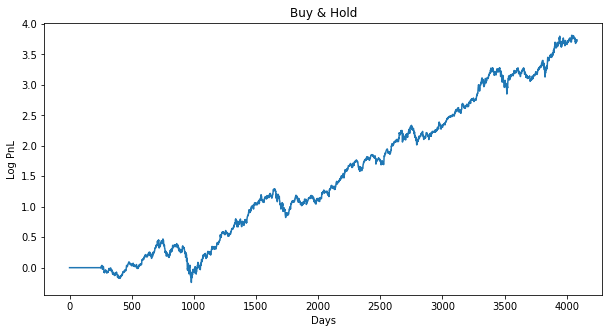

In [91]:
rets_df = calc_returns(mdf)
navs_df = pd.DataFrame(np.full(mdf.shape, START_NAV / PARTS_NUM))
navs_df = calc_cum_returns(navs_df, rets_df, START_PERIOD)
nav_total = calc_total_nav(navs_df)
results_df = plot_log_pnl(nav_total, "Buy & Hold", results_df)

Buy & Hold rebalanced:
Profit = 3817.0962952861523 %
Max DD = 46.39625711013793 %
Sharpe = 1.1002947540700596
Calmar = 82.27164286603818


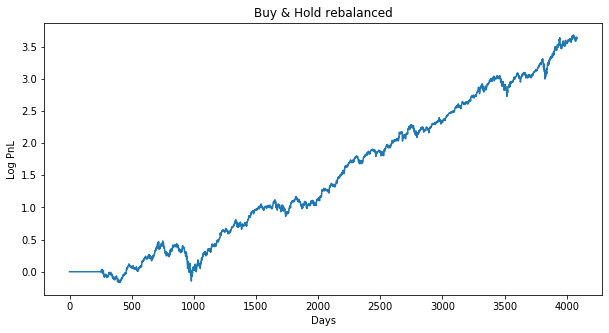

In [92]:
rb_navs_df = pd.DataFrame(np.full(mdf.shape, START_NAV / PARTS_NUM))
rb_navs_df = calc_cum_returns_with_rebalance(rb_navs_df, rets_df, START_PERIOD, REBALANCE_PERIOD)
rb_nav_total = calc_total_nav(rb_navs_df)
results_df = plot_log_pnl(rb_nav_total, "Buy & Hold rebalanced", results_df)

In [19]:
LOOKBACK_PERIOD = 252 #one year = START_PERIOD
RESID_BANDS_PERIOD = 10 # two weeks
fdf = mdf.copy() #features = deltas from year moving average
for col in mdf.columns:
    fdf[col] = calc_diff_perc_series(mdf[col], LOOKBACK_PERIOD)    

no_side_filter = np.full(fdf.shape[0], 0.5)  #all sides are allowed

In [20]:
def calc_trade_ret(target, entry_idx, exit_idx, pos):
    return target[exit_idx]  / target[entry_idx] if pos > 0 else 1.0

def calc_pos_ret(target, idx, pos):
    return target[idx]  / target[idx - 1] if pos > 0 else 1.0

def calc_sig_rets(target, long_sig, short_sig, start_period):
    pos = 0
    buy_idx = -1
    sell_idx = -1
    rets = np.ones(target.shape[0])
    for i in range(start_period, target.shape[0], 1):
        rets[i] = calc_pos_ret(target, i, pos)
        if (pos < 1) and long_sig[i]:
            buy_idx = i
            #if sell_idx > 0:
            #    rets[i] = calc_trade_ret(target.values, sell_idx, buy_idx, pos)
            pos = 1
        elif (pos > -1) and short_sig[i]:
            sell_idx = i
            #if buy_idx > 0:
            #    rets[i] = calc_trade_ret(target.values, buy_idx, sell_idx, pos)
            pos = 0 #use -1 for reversal strategy
    return rets

In [21]:
def evaluate_estimator(fdf, online_estimator, bbands_period, side_filter):
    rets_df = fdf.copy()
    for target_col in fdf.columns:
        
        #calculate residuals using estimator 
        inputs = extract_X(fdf, fdf.columns)
        target = extract_y(fdf, target_col)
        eval_target = extract_y(mdf, target_col)
        if online_estimator.exclude_target:
            inputs = target_to_const(inputs, target_col)
        resids = online_estimator.calc_resids(inputs, target)
        resid_ser = pd.Series(resids)
    
        #calculate residuals' bands
        resid_ewm = resid_ser.ewm(span=bbands_period)
        upband = (+resid_ewm.std() + resid_ewm.mean()).shift()
        dnband = (-resid_ewm.std() + resid_ewm.mean()).shift()

        #calculate long shor signals
        long_sig = (resid_ser < dnband ) # * (side_filter > 0) #filter entries
        short_sig = (resid_ser > upband) * (side_filter < 1) #filter exits
        
        #get returns based on signals
        rets_df[target_col] = calc_sig_rets(eval_target, long_sig, short_sig, LOOKBACK_PERIOD)
    return rets_df

In [22]:
# Ridge params
alpha = 0.1 # for regularization since we have correlated features
exclude_target = True
online_ridge = OnlineRidge(exclude_target, LOOKBACK_PERIOD, alpha)
lr_rets_df = evaluate_estimator(fdf, online_ridge, RESID_BANDS_PERIOD, no_side_filter)

Online lreg rebalanced:
Profit = 1016.6920988774672 %
Max DD = 16.397665825442854 %
Sharpe = 1.2195254708330439
Calmar = 62.002245301276545


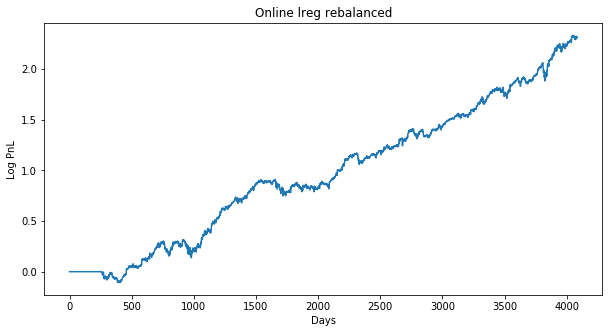

In [94]:
lr_navs_df = pd.DataFrame(np.full(mdf.shape, START_NAV / PARTS_NUM))
lr_navs_df = calc_cum_returns_with_rebalance(lr_navs_df, lr_rets_df, START_PERIOD, REBALANCE_PERIOD)
lr_nav_total = calc_total_nav(lr_navs_df)
results_df = plot_log_pnl(lr_nav_total, "Online lreg rebalanced", results_df)

In [95]:
components_num = 2
exclude_target = False
online_pca = OnlinePCA(exclude_target, LOOKBACK_PERIOD, components_num, alpha)
pca_rets_df = evaluate_estimator(fdf, online_pca, RESID_BANDS_PERIOD, no_side_filter)

Online PCA rebalanced:
Profit = 1054.6297690085303 %
Max DD = 18.861411864984056 %
Sharpe = 1.1416941230149202
Calmar = 55.9146778914486


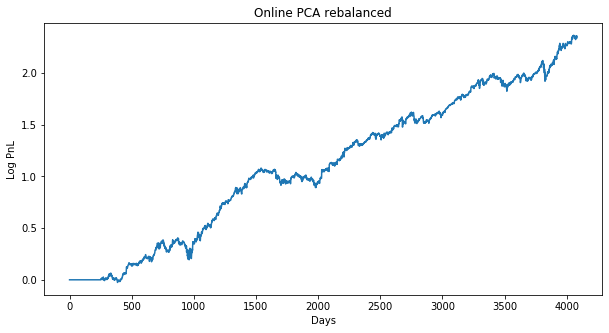

In [96]:
pca_navs_df = pd.DataFrame(np.full(mdf.shape, START_NAV / PARTS_NUM))
pca_navs_df = calc_cum_returns_with_rebalance(pca_navs_df, pca_rets_df, START_PERIOD, REBALANCE_PERIOD)
pca_nav_total = calc_total_nav(pca_navs_df)
results_df = plot_log_pnl(pca_nav_total, "Online PCA rebalanced", results_df)

In [97]:
delta = 0.001
exclude_target = True
err_period = RESID_BANDS_PERIOD
online_kalman = OnlineKalman(exclude_target, delta, err_period, alpha)
kal_rets_df = evaluate_estimator(fdf, online_kalman, RESID_BANDS_PERIOD, no_side_filter)

Online Kalman rebalanced:
Profit = 1215.16351476158 %
Max DD = 21.767128119611712 %
Sharpe = 1.2815306023490904
Calmar = 55.825624220346455


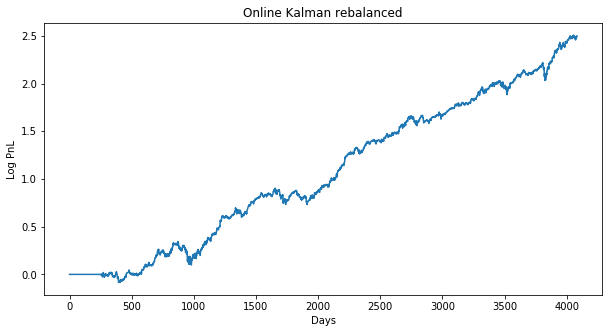

In [98]:
kal_navs_df = pd.DataFrame(np.full(mdf.shape, START_NAV / PARTS_NUM))
kal_navs_df = calc_cum_returns_with_rebalance(kal_navs_df, kal_rets_df, START_PERIOD, REBALANCE_PERIOD)
kal_nav_total = calc_total_nav(kal_navs_df)
results_df = plot_log_pnl(kal_nav_total, "Online Kalman rebalanced", results_df)

In [99]:
vix_adj_close_cols = [('Adj Close', '^VIX')] #using VIX index
vdf = yf_prices_df[vix_adj_close_cols] #take only adjusted closes
vdf.index = dates.values
vdf.columns=[x[1] for x in vdf.columns[0:vdf.shape[1]]] #simplify columns
vdf = vdf.ffill().bfill().iloc[1:] # removing NaNs using bfill and ffill and first row NaNs

In [100]:
target_period = 21 # target lookforward
states_num = 2 # two hidden markov states
idx_col = "QQQ" # let's take sector performanceindex
idx_df = fdf[[idx_col]] # it's year diffs with mean
idx_df['delta'] = calc_diff_perc_series(mdf[idx_col], target_period) #short period deltas  
idx_df['vix_delta'] = calc_diff_perc_series(vdf["^VIX"], target_period) #short period deltas of VIX   
idx_df['target'] = target_roll_reg(mdf[idx_col], target_period) #smoothed by timed linear regression target to reduce noise
exit_side_filter = calc_rolling_hmm_flags(idx_df, states_num, 'target', LOOKBACK_PERIOD, target_period) #calculate online hmm for these features

Online Kalman rebalanced with regimes:
Profit = 3192.070341738197 %
Max DD = 27.74982094171382 %
Sharpe = 1.163528804807663
Calmar = 115.03030410332643


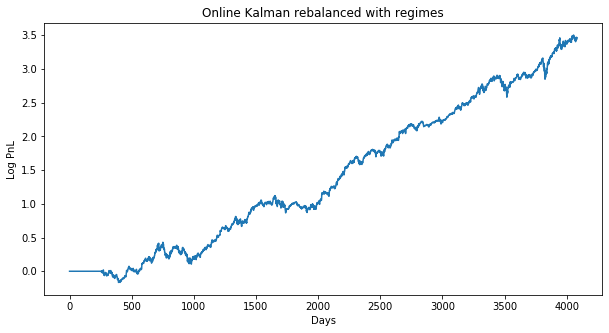

In [101]:
kalhmm_rets_df = evaluate_estimator(fdf, online_kalman, RESID_BANDS_PERIOD, exit_side_filter)
kalhmm_navs_df = pd.DataFrame(np.full(mdf.shape, START_NAV / PARTS_NUM))
kalhmm_navs_df = calc_cum_returns_with_rebalance(kalhmm_navs_df, kalhmm_rets_df, START_PERIOD, REBALANCE_PERIOD)
kalhmm_nav_total = calc_total_nav(kalhmm_navs_df)
results_df = plot_log_pnl(kalhmm_nav_total, "Online Kalman rebalanced with regimes", results_df)

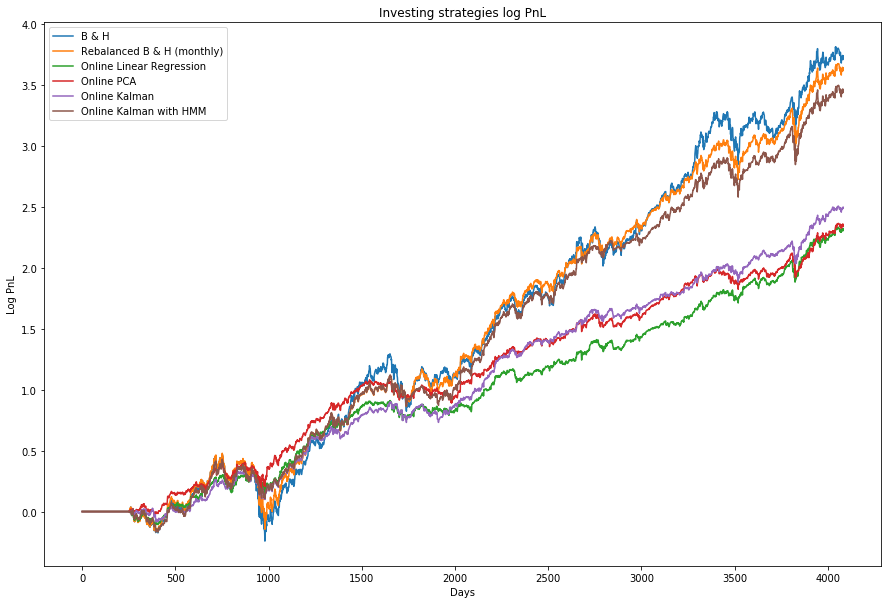

In [102]:
plt.figure(figsize = (15,10))
plt.title("Investing strategies log PnL")
plt.ylabel('Log PnL')
plt.xlabel('Days')
plt.plot(calc_log_nav(nav_total), label = "B & H")
plt.plot(calc_log_nav(rb_nav_total), label = "Rebalanced B & H (monthly)")
plt.plot(calc_log_nav(lr_nav_total), label = "Online Linear Regression")
plt.plot(calc_log_nav(pca_nav_total), label = "Online PCA")
plt.plot(calc_log_nav(kal_nav_total), label = "Online Kalman")
plt.plot(calc_log_nav(kalhmm_nav_total), label = "Online Kalman with HMM")
plt.legend(loc="upper left")
plt.show()

In [103]:
results_df

,Strategy name,PnL%,Max drawdown %,Sharpe,Calmar
0,Buy & Hold,4199.219650,50.931769,1.004656,82.447945
1,Buy & Hold rebalanced,3817.096295,46.396257,1.100295,82.271643
2,Online lreg rebalanced,1016.692099,16.397666,1.219525,62.002245
3,Online PCA rebalanced,1054.629769,18.861412,1.141694,55.914678
4,Online Kalman rebalanced,1215.163515,21.767128,1.281531,55.825624
5,Online Kalman rebalanced with regimes,3192.070342,27.749821,1.163529,115.030304
